# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

Загрузим данные, используя разделитель значений в строке — `\t`, выведем общую информацию по таблице.

In [1]:
import pandas as pd
import math
from IPython.display import display
import matplotlib.pyplot as plt

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

**Вывод:** дататасет состоит из 22 столбцов и 23699 строк. Названия столбцов не требуют изменений. Нулевые значения содержатся в следующих столбцах:

- высота потолков (м)
- всего этажей в доме
- жилая площадь в квадратных метрах(м²)
- апартаменты (булев тип)
- площадь кухни в квадратных метрах (м²)
- число балконов
- название населённого пункта
- расстояние до ближайшего аэропорта в метрах (м)
- расстояние до центра города (м)
- число парков в радиусе 3 км
- расстояние до ближайшего парка (м)
- число водоёмов в радиусе 3 км
- расстояние до ближайшего водоёма (м)
- сколько дней было размещено объявление (от публикации до снятия)

### Шаг 2. Предобработка данных

Обработаем пропуски в столбцах, необходимых для исследования.

В столбце `ceiling_height` 9195 пропусков. Заменим пропуски на медианное значение.

In [2]:
data.loc[data['ceiling_height'].isnull(), 'ceiling_height'] = data['ceiling_height'].median()

В столбце `cityCenters_nearest` 5519 пропусков. Заменим пропуски в Санкт-Петербурге на медианное расстояние до центра города, для остальных населенных пунктов — на медианное значение по населенным пунктам.

Найдём медианное расстояние до центра города для Санкт-Петербурга.

In [3]:
cityCenters_nearest_median_S_P = data.query('locality_name == "Санкт-Петербург"')['cityCenters_nearest'].median()
cityCenters_nearest_median_S_P

12244.5

Найдём медианное расстояние до центра для остальных населённых пунктов.

In [4]:
cityCenters_nearest_median_not_S_P = data.query('locality_name != "Санкт-Петербург"')['cityCenters_nearest'].median()
cityCenters_nearest_median_not_S_P

30308.5

Заменим пропуски в Санкт-Петербурге.

In [5]:
data.loc[(data['locality_name'] == 'Санкт-Петербург') & (data['cityCenters_nearest'].isnull()), \
         'cityCenters_nearest'] = cityCenters_nearest_median_S_P

Заменим пропуски для остальных населенных пунктов.

In [6]:
data.loc[(data['locality_name'] != 'Санкт-Петербург') & (data['cityCenters_nearest'].isnull()), \
         'cityCenters_nearest'] = cityCenters_nearest_median_not_S_P

В столбце `balcony` 11519 пропусков. Предположим, что балконы отсутствуют. Заменим пропуски нулевыми значениями.

In [7]:
data.loc[data['balcony'].isnull(), 'balcony'] = 0

В столбце `floors_total` 86 пропусков. Заменим их значениями стобца `floor`, предположив, что этаж последний.

In [8]:
data.loc[data['floors_total'].isnull(), 'floors_total'] = data.loc[data['floors_total'].isnull(), 'floor']

В столбце `days_exposition` 3181 пропусков. Предположим, пропуски означают, что квартиры ещё находятся в продаже, и оставим их без изменения.

Проанализируем названия населённых пунктов методом `value_counts()`. После выполнения код закомментируем.

In [9]:
# data['locality_name'].value_counts()

Во-первых, строки в столбце имеют разный регистр. Приведём всё к нижнему регистру вызовом метода `lower()`.

In [10]:
data['locality_name'] = data['locality_name'].str.lower()

Во-вторых, применяются и буква *е*, и буква *ё*, например, *поселок Победа* и *посёлок Победа*. Заменим *е* на *ё* методом `replace()`.

In [11]:
data['locality_name'] = data['locality_name'].str.replace('ё','е')

В столбце `rooms` 197 квартир с числом комнат равным 0. Предположим, что это аномалия, и заменим число комнат на значение 1.

In [12]:
# data['rooms'].value_counts() # подсчёт квартир с числом комнат равным 0
data.loc[data['rooms'] == 0, 'rooms'] = 1

**Замена типа данных**

Преобразуем строки в столбце `first_day_exposition` в формат даты.

In [13]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

В следующих столбцах можно изменить тип данных:

- `floors_total` — с вещественного на целочисленный, потому что количество этажей — целое число:

In [14]:
data['floors_total'] = data['floors_total'].astype('int')

- `balcony` — с вещественного на целочисленный, потому что количество балконов — целое число:

In [15]:
data['balcony'] = data['balcony'].astype('int')

**Вывод:** обработаны пропуски в следующих столбцах, необходимых для исследования: высота потолков, расстояние до центра города (с разделением на Санкт-Петербург и прочие населённые пункты), число балконов, количество этажей в доме. Столбец дней размещения объявления оставлен без изменений. Обработаны названия населённых пунктов и число комнат. Столбец даты публикации преобразован в формат даты. Столбцам количества этажей в доме и числа балконов изменён тип данных на целочисленный.

### Шаг 3. Посчитайте и добавьте в таблицу

- Посчитаем и добавим в таблицу цену квадратного метра `square_meter_price`.

In [16]:
data['square_meter_price'] = data['last_price'] / data['total_area']

- Посчитаем и добавим в таблицу день недели публикации объявления `exposition_day`.

In [17]:
data['exposition_day'] = data['first_day_exposition'].dt.weekday

Заменим цифры названиями дней недели методом `replace()`.

In [18]:
data['exposition_day'] = data['exposition_day'].replace(
    {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'})

- Посчитаем и добавим в таблицу месяц публикации объявления `exposition_month`.

In [19]:
data['exposition_month'] = data['first_day_exposition'].dt.month

Заменим числа названиями месяцев методом `replace()`.

In [20]:
data['exposition_month'] = data['exposition_month'].replace(
    {1: 'Январь', 2: 'Февраль', 3: 'Март', 4: 'Апрель', 5: 'Май', 6: 'Июнь',
     7: 'Июль', 8: 'Август', 9: 'Сентябрь', 10: 'Октябрь', 11: 'Ноябрь', 12: 'Декабрь'})

- Посчитаем и добавим в таблицу год публикации объявления `exposition_year`.

In [21]:
data['exposition_year'] = data['first_day_exposition'].dt.year

- Посчитаем и добавим в таблицу этаж квартиры `floor_category`. Скопируем значения из столбца `floor` и заменим 1 на значение `'Первый'`.

In [22]:
data['floor_category'] = data['floor']
data['floor_category'] = data['floor_category'].replace(1, 'Первый')

Заменим этажи, совпадающие с общим количеством этажей в доме `floors_total`, на значение `'Последний'`.

In [23]:
data.loc[data['floor_category'] == data['floors_total'], 'floor_category'] = 'Последний'

Заменим оставшиеся этажи на значение `'Другой'` методом `where()`.

In [24]:
data['floor_category'] = data['floor_category'].where(data['floor_category'].isin(['Первый', 'Последний']), 'Другой')

- Посчитаем и добавим в таблицу соотношение жилой и общей площади `living_total_ratio`.

In [25]:
data['living_total_ratio'] = data['living_area'] / data['total_area']

Заполним пропуски в столбце `living_total_ratio` средним значением `living_total_ratio_mean` и на его основе заполним пропуски в столбце `living_area`.

In [26]:
living_total_ratio_mean = data['living_total_ratio'].mean()
data.loc[data['living_total_ratio'].isnull(), 'living_total_ratio'] = living_total_ratio_mean
data.loc[data['living_area'].isnull(), 'living_area'] = data['total_area'] * living_total_ratio_mean

- Посчитаем и добавим в таблицу отношение площади кухни к общей `kitchen_total_ratio`.

In [27]:
data['kitchen_total_ratio'] = data['kitchen_area'] / data['total_area']

Заполним пропуски в столбце `kitchen_total_ratio` средним значением `kitchen_total_ratio_mean` и на его основе заполним пропуски в столбце `kitchen_area`.

In [28]:
kitchen_total_ratio_mean = data['kitchen_total_ratio'].mean()
data.loc[data['kitchen_total_ratio'].isnull(), 'kitchen_total_ratio'] = kitchen_total_ratio_mean
data.loc[data['kitchen_area'].isnull(), 'kitchen_area'] = data['total_area'] * kitchen_total_ratio_mean

**Вывод:** в таблицу добавлены следующие столбцы: цена квадратного метра; день недели, месяц (день недели и месяц категорированы) и год публикации объявления; этаж квартиры; варианты — первый, последний, другой; соотношение жилой и общей площади, а также отношение площади кухни к общей (на их основе заполнены пропуски в стобцах жилой площади и площади кухни).

### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

Изучим параметр площадь методом `boxplot()`.

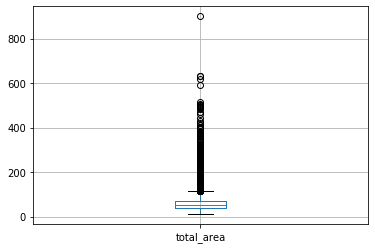

In [29]:
data.boxplot(column=['total_area'])

И методом `describe()`.

In [30]:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

**Вывод:** квартиры площадью больше 70 м² (третий квартиль) отличаются большим разбросом.

Построим гистограмму для параметра площадь.

Text(0.5, 1.0, 'Гистограмма для параметра площадь')

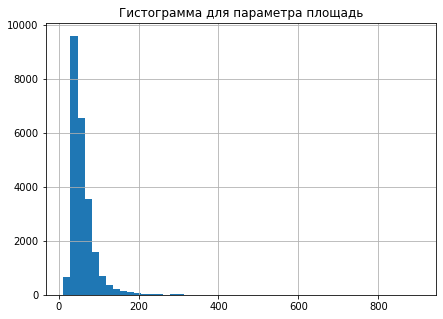

In [31]:
data['total_area'].hist(bins=50, figsize=(7, 5))
plt.title('Гистограмма для параметра площадь')

Добавлены заголовки для каждого графика.

Построим гистограмму без выбросов для параметра площадь.

Text(0.5, 1.0, 'Гистограмма без выбросов для параметра площадь')

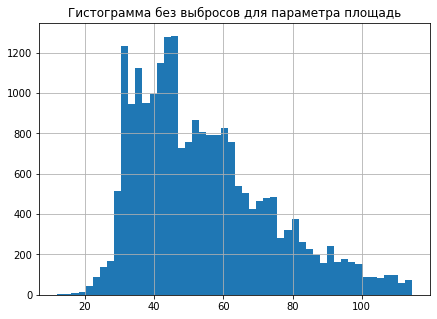

In [32]:
total_area_Q1 = data['total_area'].describe()[4] # первый квартиль
total_area_Q3 = data['total_area'].describe()[6] # третий квартиль
total_area_IQR = total_area_Q3 - total_area_Q1 # межквартильный размах
(data
     .query('@total_area_Q1 - 1.5*@total_area_IQR < total_area < @total_area_Q3 + 1.5*@total_area_IQR')
     ['total_area'].hist(bins=50, figsize=(7, 5))
)
plt.title('Гистограмма без выбросов для параметра площадь')

Изучим параметр цена методом `boxplot()`.

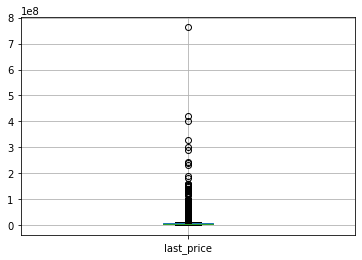

In [33]:
data.boxplot(column=['last_price'])

И методом `describe()`.

In [34]:
data['last_price'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

**Вывод:** квартиры стоимостью выше 7 миллионов (третий квартиль) отличаются большим разбросом.

Построим гистограмму для параметра цена.

Text(0.5, 1.0, 'Гистограмма для параметра цена')

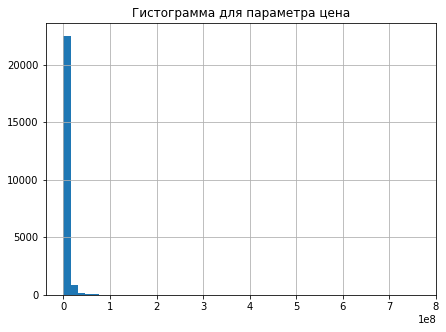

In [35]:
data['last_price'].hist(bins=50, figsize=(7, 5))
plt.title('Гистограмма для параметра цена')

Построим гистограмму без выбросов для параметра цена.

Text(0.5, 1.0, 'Гистограмма без выбросов для параметра цена')

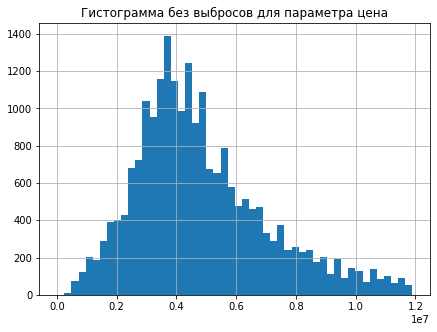

In [36]:
last_price_Q1 = data['last_price'].describe()[4] # первый квартиль
last_price_Q3 = data['last_price'].describe()[6] # третий квартиль
last_price_IQR = last_price_Q3 - last_price_Q1 #  межквартильный размах
(data
     .query('@last_price_Q1 - 1.5*@last_price_IQR < last_price < @last_price_Q3 + 1.5*@last_price_IQR')
     ['last_price'].hist(bins=50, figsize=(7, 5))
)
plt.title('Гистограмма без выбросов для параметра цена')

Изучим параметр число комнат методом `boxplot()`.

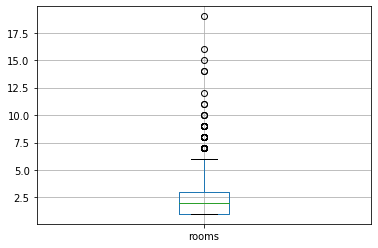

In [37]:
data.boxplot(column=['rooms'])

И методом `describe()`.

In [38]:
data['rooms'].describe()

count    23699.000000
mean         2.078948
std          1.066196
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

Построим гистограмму для числа комнат.

Text(0.5, 1.0, 'Гистограмма для числа комнат')

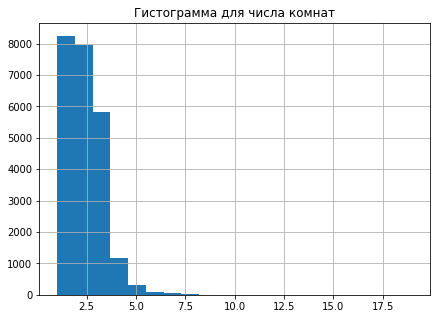

In [39]:
data['rooms'].hist(bins=20, figsize=(7, 5))
plt.title('Гистограмма для числа комнат')

**Вывод:** чаще всего встречаются одно- и двухкомнатные квартиры. Квартиры, в которых больше четырёх комнат, встречаются редко.

Построим гистограмму без выбросов для числа комнат.

Text(0.5, 1.0, 'Гистограмма без выбросов для числа комнат')

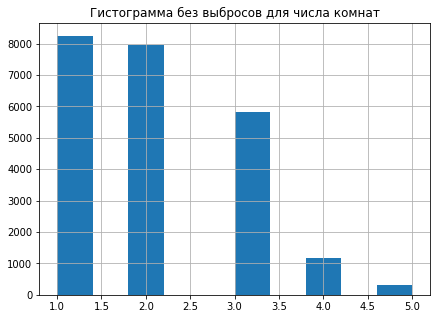

In [40]:
rooms_Q1 = data['rooms'].describe()[4] # первый квартиль
rooms_Q3 = data['rooms'].describe()[6] # третий квартиль
rooms_IQR = rooms_Q3 - rooms_Q1 #  межквартильный размах
(data
     .query('@rooms_Q1 - 1.5*@rooms_IQR < rooms < @rooms_Q3 + 1.5*@rooms_IQR')
     ['rooms'].hist(bins=10, figsize=(7, 5))
)
plt.title('Гистограмма без выбросов для числа комнат')

Изучим параметр высота потолков методом `boxplot()`.

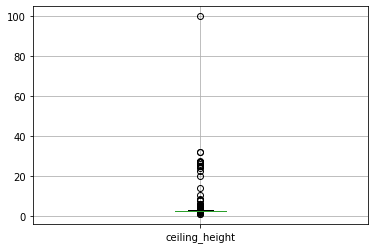

In [41]:
data.boxplot(column=['ceiling_height'])

И методом `describe()`.

In [42]:
data['ceiling_height'].describe()

count    23699.000000
mean         2.724358
std          0.988298
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

**Вывод:** большинство потолков в квартирах находятся в диапазоне от 2,5 до 3 метров.

Построим гистограмму для высоты потолков.

Text(0.5, 1.0, 'Гистограмма без выбросов для высоты потолков')

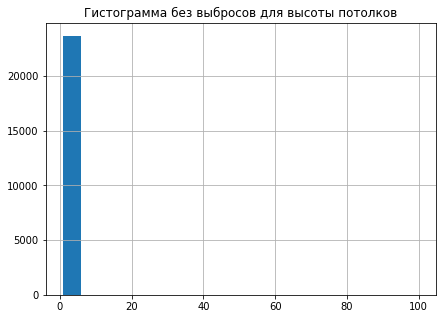

In [43]:
data['ceiling_height'].hist(bins=20, figsize=(7, 5))
plt.title('Гистограмма без выбросов для высоты потолков')

Построим гистограмму без выбросов для параметра высота потолков.

Text(0.5, 1.0, 'Гистограмма без выбросов для высоты потолков')

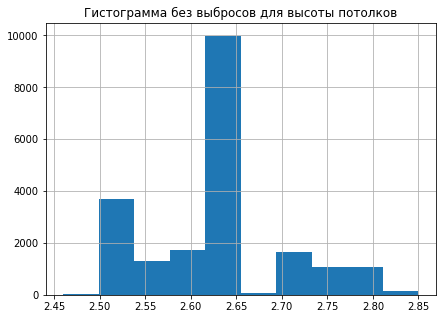

In [44]:
ceiling_height_Q1 = data['ceiling_height'].describe()[4] # первый квартиль
ceiling_height_Q3 = data['ceiling_height'].describe()[6] # третий квартиль
ceiling_height_IQR = ceiling_height_Q3 - ceiling_height_Q1 #  межквартильный размах
(data
     .query('@ceiling_height_Q1 - 1.5 * @ceiling_height_IQR < ceiling_height < @ceiling_height_Q3 + 1.5 * @ceiling_height_IQR')
     ['ceiling_height'].hist(bins=10, figsize=(7, 5))
)
plt.title('Гистограмма без выбросов для высоты потолков')

Изучим время продажи квартиры методом `boxplot()`.

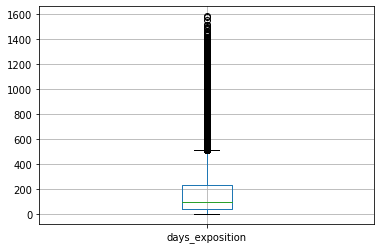

In [45]:
data.boxplot(column=['days_exposition'])

И методом `describe()`.

In [46]:
data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

Построим гистограмму времени продажи квартиры.

Интереснее создать функцию `outlier_erase_func`, удаляющую выбросы за пределами расстояния, равного 1,5 межквартильным размахам (IQR), для использования в последующих проектах. (Возможно, есть библиотеки с готовыми функциями?)

In [47]:
def outlier_erase_func(intro_dataframe, intro_columns):
    """
    Функция получает на вход объект DataFrame и названия столбцов в виде списка,
    для каждого из них вычисляет первый и третий квартиль методом describe(),
    находит межквартильный размах и сохраняет данные
    за пределами расстояния, равного 1,5 межквартильным размахам (IQR)
    """
    try:
        outro_dataframe = []
        for i in intro_columns:
            Q = intro_dataframe[i].describe()
            Q1 = Q[4] # первый квартиль
            Q3 = Q[6] # третий квартиль
            IQR = Q3 - Q1 # межквартильный размах
            outro_dataframe = intro_dataframe.loc[(intro_dataframe[i] > Q1 - 1.5*IQR) & \
                                                  (intro_dataframe[i] < Q3 + 1.5*IQR), :]
            intro_dataframe = outro_dataframe # для сохранения результатов фильтрации
    except:
        print('Ошибка!')

    return outro_dataframe

data2 = data
good_data_2 = outlier_erase_func(data2, ['total_area', 'last_price', 'rooms', 'ceiling_height'])
good_data_2.shape[0]

13764

Однако функция содержит ошибку (неправильное объединение таблиц?), так как убирает слишком много данных в сравнении с `query()`. Надёжнее делать срезы последовательно, удаляя редкие и выбивающиеся значения.

Построим гистограмму времени продажи квартиры.

Text(0.5, 1.0, 'Гистограмма времени продажи квартиры')

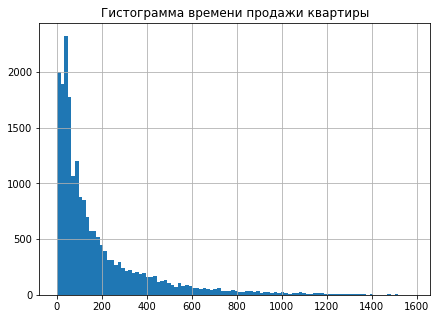

In [48]:
data['days_exposition'].hist(bins=100, figsize=(7, 5))
plt.title('Гистограмма времени продажи квартиры')

**Вывод:** среднее время продажи квартиры составляет 180 суток, медиана вполовину меньше — 95. Очень быстрыми можно считать продажи менее трёх месяцев, необычно долгими — свыше восьми.

Уберём редкие и выбивающиеся значения, сделав срезы методом `query()` по ранее исследованным параметрам.

In [49]:
good_data = (
    data
    .query('@total_area_Q1 - 1.5*@total_area_IQR < total_area < @total_area_Q3 + 1.5*@total_area_IQR')
    .query('@last_price_Q1 - 1.5*@last_price_IQR < last_price < @last_price_Q3 + 1.5*@last_price_IQR')
    .query('@rooms_Q1 - 1.5*@rooms_IQR < rooms < @rooms_Q3 + 1.5*@rooms_IQR')
    .query('@ceiling_height_Q1 - 1.5*@ceiling_height_IQR < ceiling_height < @ceiling_height_Q3 + 1.5*@ceiling_height_IQR')
)
good_data.shape[0]

19533

**Вывод:** в датасете были квартиры с высотой потолков менее 2 метров, выше 8 и даже 100 метров. Это очевидные аномалии. Недвижимость с экстремальной площадью (> 400 м²), ценой (763 млн) или количеством комнат (19) скорее всего существует, но в выборку не попала.

Изучим факторы, влияющие на стоимость квартиры. Найдём зависимость цены от площади, числа комнат, удалённости от центра. Для этого посчитаем коэффициенты корреляции Пирсона методом `corr()`.

In [50]:
display(
    'Зависимость цены от площади:', good_data['last_price'].corr(data['total_area']),
    'Зависимость цены от числа комнат:', good_data['last_price'].corr(data['rooms']),
    'Зависимость цены от удалённости от центра:', good_data['last_price'].corr(data['cityCenters_nearest'])
)

'Зависимость цены от площади:'

0.6781069432355287

'Зависимость цены от числа комнат:'

0.4098867424101582

'Зависимость цены от удалённости от центра:'

-0.5105470924091925

Построим матрицы рассеяния методом `pd.plotting.scatter_matrix(df)` для указанных параметров.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f25aa9c73d0>,
      dtype=object)

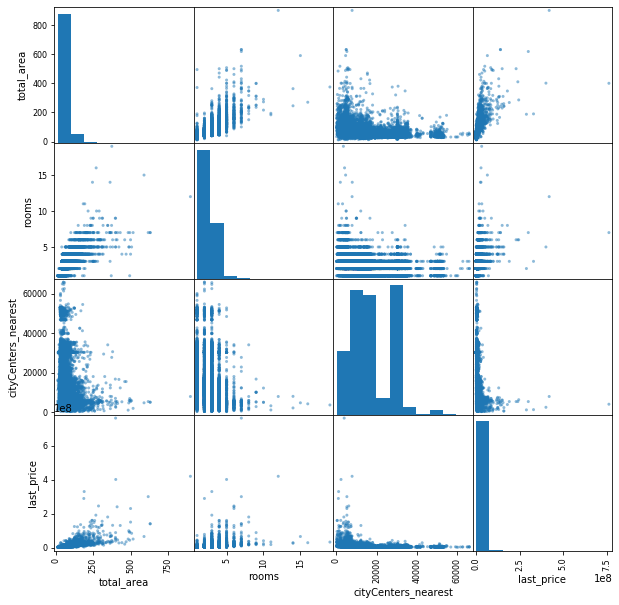

In [51]:
pd.plotting.scatter_matrix(data[['total_area', 'rooms', 'cityCenters_nearest', 'last_price']], figsize=(10, 10))

**Вывод:** стоимость квартиры зависит от площади и слабо зависит от числа комнат и удалённости от центра.

Изучим зависимость цены от того, на каком этаже расположена квартира: первом, последнем или другом. Для этого создадим сводную таблицу `floor_category_data`, сгруппировав стоимость квартир по расположениям этажей и рассчитав медианное значение по каждой категории. Построим гистограмму медианных значений стоимости методом `plot()`.

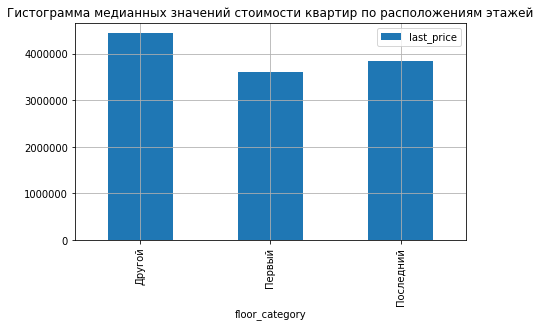

In [52]:
floor_category_data = good_data.pivot_table(index='floor_category', values='last_price', aggfunc='median')
floor_category_data.plot(y='last_price', kind='bar', \
                         title='Гистограмма медианных значений стоимости квартир по расположениям этажей', \
                         grid=True, figsize=(7, 4))

**Вывод:** первые этажи ожидаемо самые дешёвые.

Изучим зависимость стоимость квартиры от даты размещения: дня недели. Для этого создадим сводную таблицу `exposition_day_data`, сгруппировав стоимость квартир по дням публикации и рассчитав медианное значение по каждой категории. Отсортируем таблицу по возрастанию медианных значений стоимости и выведем на экран.

In [53]:
exposition_day_data = good_data.pivot_table(index='exposition_day', values='last_price', aggfunc='median')
exposition_day_data = exposition_day_data.sort_values(by='last_price', ascending=False)
display(exposition_day_data)

,last_price
exposition_day,
Понедельник,4300000.0
Среда,4300000.0
Воскресенье,4250000.0
Вторник,4250000.0
Суббота,4250000.0
Пятница,4200000.0
Четверг,4200000.0


**Вывод:** зависимость стоимости квартиры от дня размещения неочевидна. Квартиры дороже всего в начале недели.

Изучим зависимость стоимость квартиры от даты размещения: месяца. Для этого создадим сводную таблицу `exposition_month_data`, сгруппировав стоимость квартир по дням публикации и рассчитав медианное значение по каждой категории. Отсортируем таблицу по возрастанию медианных значений стоимости и построим гистограмму `plot()`.

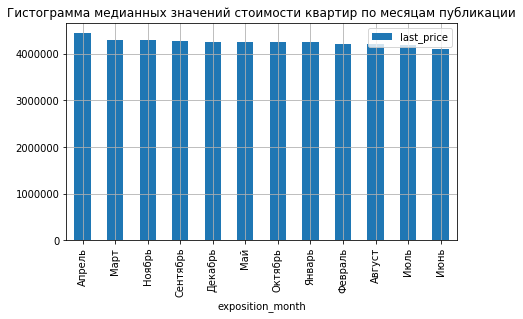

In [54]:
exposition_month_data = good_data.pivot_table(index='exposition_month', values='last_price', aggfunc='median')
exposition_month_data = exposition_month_data.sort_values(by='last_price', ascending=False)
# display(exposition_month_data)
exposition_month_data.plot(y='last_price', kind='bar', \
                           title='Гистограмма медианных значений стоимости квартир по месяцам публикации', \
                           grid=True, figsize=(7, 4))

**Вывод:** зависимость стоимости квартиры от месяца размещения неочевидна. Летом продают самые дешёвые квартиры, весной и осенью — самые дорогие.

Изучим зависимость стоимость квартиры от даты размещения: года. Для этого создадим сводную таблицу `exposition_year_data`, сгруппировав стоимость квартир по годам публикации и рассчитав медианное значение по каждой категории.

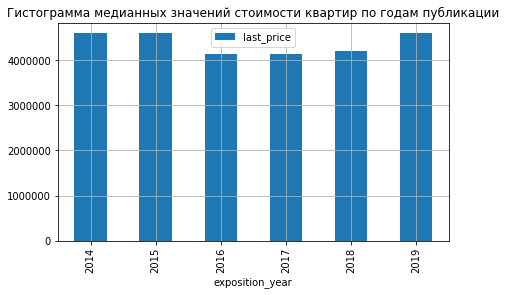

In [55]:
exposition_year_data = good_data.pivot_table(index='exposition_year', values='last_price', aggfunc='median')
exposition_year_data.plot(y='last_price', kind='bar', \
                          title='Гистограмма медианных значений стоимости квартир по годам публикации', \
                          grid=True, figsize=(7, 4))
# display(exposition_year_data)

**Вывод:** стоимость квартиры просела в период с 16-го по 18-й годы.

Выберем 10 населённых пунктов с наибольшим числом объявлений. Создадим сводную таблицу `top_locality_exposition`, сгруппировав по населённым пунктам и найдя количество объявлений и среднюю цену квадратного метра. Изменим заголовки: `number` — для количества объявлений, `avg_square_meter_price` — для средней цены квадратного метра. Выведем первые десять населённых пунктов по количеству объявлений.

In [56]:
top_locality_exposition = good_data.pivot_table(index='locality_name', values='square_meter_price', aggfunc=['count', 'mean'])
top_locality_exposition.columns = ['number', 'avg_square_meter_price']
display(top_locality_exposition.sort_values(by='number', ascending=False).head(10))

,number,avg_square_meter_price
locality_name,,
санкт-петербург,12056,104687.615294
поселок мурино,549,85667.449003
поселок шушары,434,78676.193309
всеволожск,380,67109.995394
поселок парголово,325,90362.345200
колпино,315,75407.591217
пушкин,299,99659.197721
деревня кудрово,296,92489.244005
гатчина,283,68340.849581


Выведем десять населённых пунктов с самой высокой стоимостью жилья.

In [57]:
display(top_locality_exposition.sort_values(by='avg_square_meter_price', ascending=False).head(10))

,number,avg_square_meter_price
locality_name,,
поселок лисий нос,2,113728.348730
санкт-петербург,12056,104687.615294
сестрорецк,143,100878.712040
зеленогорск,20,100123.734519
кудрово,170,99899.555066
пушкин,299,99659.197721
деревня мистолово,11,98549.976709
поселок левашово,1,96997.690531
мурино,34,92722.708914


И с самой низкой стоимостью жилья.

In [58]:
display(top_locality_exposition.sort_values(by='avg_square_meter_price').head(10))

,number,avg_square_meter_price
locality_name,,
деревня старополье,3,11206.221198
поселок станции свирь,2,11481.481481
деревня вахнова кара,1,11688.311688
деревня выскатка,2,12335.480902
поселок совхозный,2,12629.129129
деревня малая романовка,1,12724.550898
поселок тесово-4,1,12931.034483
деревня бор,1,13157.894737
деревня сижно,1,13709.677419


**Вывод:** больше всего объявлений и одни из самых дорогих квартир в Санкт-Петербурге. Самая низкая стоимость жилья отличается от самой высокой в десять раз.

Выделим квартиры в Санкт-Петербурге в таблицу `saint_petersburg_estate`.

In [59]:
saint_petersburg_estate = good_data.query('locality_name == "санкт-петербург"')

Создадим столбец `cityCenters_nearest_km`. Скопируем `cityCenters_nearest`, преобразуем в расстояние до центра в километрах, поделив на тысячу, и округлим до целых значений.

In [60]:
saint_petersburg_estate['cityCenters_nearest_km'] = saint_petersburg_estate['cityCenters_nearest']
saint_petersburg_estate.loc[:, 'cityCenters_nearest_km'] /= 1000
saint_petersburg_estate.loc[:, 'cityCenters_nearest_km'] = saint_petersburg_estate['cityCenters_nearest_km'].round(0)
# saint_petersburg_estate['cityCenters_nearest_km'].head(20)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Заменим нулевые значения на единицу, чтобы избежать деления на ноль, и посчитаем среднюю цену для каждого километра.

In [61]:
saint_petersburg_estate.loc[saint_petersburg_estate['cityCenters_nearest_km'] == 0, 'cityCenters_nearest_km'] = 1
saint_petersburg_estate.loc[:, 'avg_kilometer_price'] = saint_petersburg_estate['last_price'] / saint_petersburg_estate['cityCenters_nearest_km']

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)


Построим график, показывающий как цена зависит от удалённости от центра.

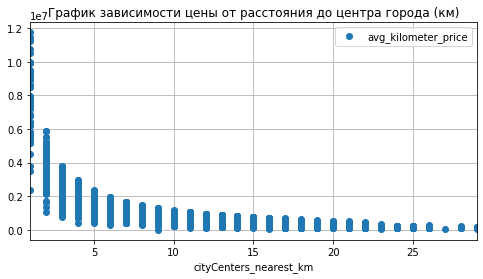

In [62]:
saint_petersburg_estate.plot(x='cityCenters_nearest_km', y='avg_kilometer_price', \
                             title='График зависимости цены от расстояния до центра города (км)', style='o', \
                             grid=True, figsize=(8, 4))

Построим другой график. Для этого cоздадим сводную таблицу `saint_petersburg_estate_center_price`, сгруппировав по расстоянию до центра в километрах и найдя медианные значения средней цены для каждого километра, и выведем её на экран. 

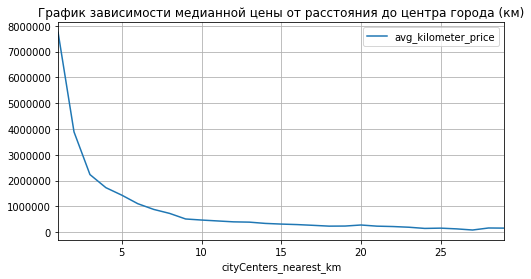

In [63]:
saint_petersburg_estate_center_price = saint_petersburg_estate.pivot_table(
    index='cityCenters_nearest_km', values='avg_kilometer_price', aggfunc='median')
saint_petersburg_estate_center_price.plot(title='График зависимости медианной цены от расстояния до центра города (км)', \
                                          grid=True, figsize=(8, 4))

**Вывод:** Как определить центральную зону? Можно считать центром расстояние до попадания в 5% коридор аналогично времени переходного процесса в теории управления, где «переходный процесс считают закончившимся, когда переходная функция отличается не более, чем на 1–5 % от своего установившегося (стационарного) значения». На графике это расстояние до 10 километров. Если считать центром границу, где график сильно меняется, тогда это расстояние от 3 до 7 километров. Для выразительности примем центром область не более 5 километров.

Выделим сегмент квартир в центре в таблицу `saint_petersburg_estate_center` и проанализируем её методом `info()`.

In [64]:
saint_petersburg_estate_center = saint_petersburg_estate.query('cityCenters_nearest_km <= 5')
saint_petersburg_estate_center.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 813 entries, 24 to 23691
Data columns (total 31 columns):
total_images              813 non-null int64
last_price                813 non-null float64
total_area                813 non-null float64
first_day_exposition      813 non-null datetime64[ns]
rooms                     813 non-null int64
ceiling_height            813 non-null float64
floors_total              813 non-null int64
living_area               813 non-null float64
floor                     813 non-null int64
is_apartment              103 non-null object
studio                    813 non-null bool
open_plan                 813 non-null bool
kitchen_area              813 non-null float64
balcony                   813 non-null int64
locality_name             813 non-null object
airports_nearest          812 non-null float64
cityCenters_nearest       813 non-null float64
parks_around3000          813 non-null float64
parks_nearest             475 non-null float64
ponds_arou

В центр попало меньше тысячи квартир. Изучим следующие параметры: площадь, цену, число комнат, высоту потолков.

count    813.000000
mean      63.740849
std       20.921457
min       12.000000
25%       46.300000
50%       62.000000
75%       79.000000
max      114.200000
Name: total_area, dtype: float64

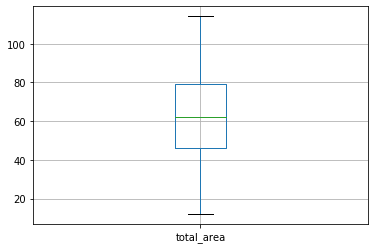

In [65]:
saint_petersburg_estate_center.boxplot(column=['total_area'])
saint_petersburg_estate_center['total_area'].describe()

count    8.130000e+02
mean     7.307225e+06
std      2.123359e+06
min      1.686000e+06
25%      5.700000e+06
50%      7.150000e+06
75%      8.800000e+06
max      1.186686e+07
Name: last_price, dtype: float64

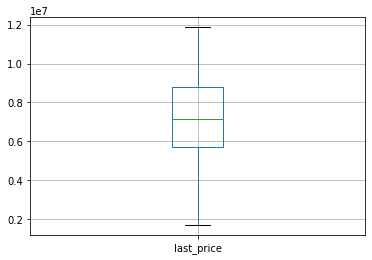

In [66]:
saint_petersburg_estate_center.boxplot(column=['last_price'])
saint_petersburg_estate_center['last_price'].describe()

Создадим список исследуемых параметров: площадь, цена, число комнат, высота потолков.

In [67]:
researched_parameters = ['total_area', 'last_price', 'rooms', 'ceiling_height']

Применим в цикле методы `boxplot()` и `describe()` к каждому исследуемому параметру.

'total_area'

count    813.000000
mean      63.740849
std       20.921457
min       12.000000
25%       46.300000
50%       62.000000
75%       79.000000
max      114.200000
Name: total_area, dtype: float64

'last_price'

count    8.130000e+02
mean     7.307225e+06
std      2.123359e+06
min      1.686000e+06
25%      5.700000e+06
50%      7.150000e+06
75%      8.800000e+06
max      1.186686e+07
Name: last_price, dtype: float64

'rooms'

count    813.000000
mean       2.221402
std        0.929900
min        1.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        5.000000
Name: rooms, dtype: float64

'ceiling_height'

count    813.000000
mean       2.671402
std        0.065968
min        2.460000
25%        2.650000
50%        2.650000
75%        2.700000
max        2.850000
Name: ceiling_height, dtype: float64

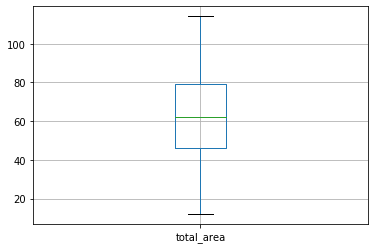

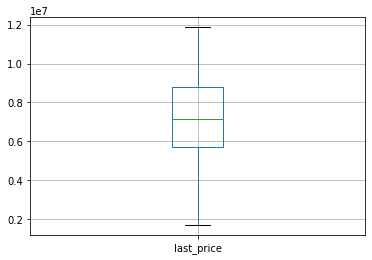

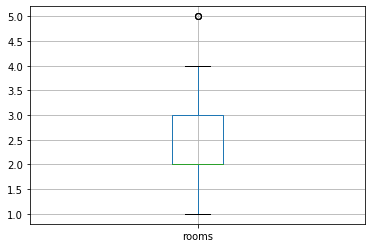

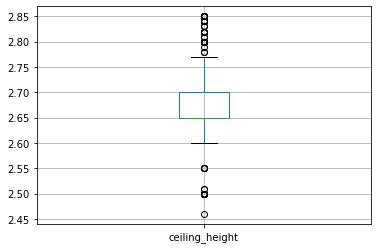

In [68]:
for i in researched_parameters:
    display(i, saint_petersburg_estate_center[i].describe())
    plt.figure()
    saint_petersburg_estate_center.boxplot(column=[i])

**Вывод:** недвижимость в центре отличается большей однородностью и дороговизной (в полтора раза по сравнению с медианой по всему набору).

In [69]:
display(
    'Зависимость цены от площади:', \
    saint_petersburg_estate_center['last_price'].corr(data['total_area']),
    'Зависимость цены от числа комнат:', \
    saint_petersburg_estate_center['last_price'].corr(data['rooms']),
    'Зависимость цены от удалённости от центра:', \
    saint_petersburg_estate_center['last_price'].corr(data['cityCenters_nearest']),
    'Зависимость цены от количества дней размещения объявления:', \
    saint_petersburg_estate_center['last_price'].corr(data['days_exposition'])
)

'Зависимость цены от площади:'

0.6896345297727068

'Зависимость цены от числа комнат:'

0.46037236649558344

'Зависимость цены от удалённости от центра:'

-0.006178556750020051

'Зависимость цены от количества дней размещения объявления:'

0.10795722263574867

**Вывод:** стоимость квартиры в центре всё также зависит от площади и мало зависит от числа комнат. Расстояние больше не влияет на цену. Продолжительность продажи не влияет на стоимость.

### Шаг 5. Общий вывод

Рынок недвижимости неоднороден. Квартиры площадью больше 70 м² и стоимостью выше 7 миллионов отличаются большим разбросом.

Чаще всего встречаются одно- и двухкомнатные квартиры. Квартиры, в которых больше четырёх комнат, встречаются редко.
Большинство потолков в квартирах находятся в диапазоне от 2,5 до 3 метров.

Среднее время продажи квартиры составляет 180 суток, медиана вполовину меньше — 95. Очень быстрыми можно считать продажи менее трёх месяцев, необычно долгими — свыше восьми.

В датасете были квартиры с высотой потолков менее 2 метров, выше 8 и даже 100 метров. Это очевидные аномалии. Недвижимость с экстремальной площадью (> 400 м²), ценой (763 млн) или количеством комнат (19) скорее всего существует, но в выборку не попала.

Стоимость квартиры зависит от площади и слабо зависит от числа комнат и удалённости от центра.

Первые этажи ожидаемо самые дешёвые.

Зависимость стоимости квартиры от дня и месяца размещения неочевидна. Квартиры дороже всего в начале недели. Летом продают самые дешёвые квартиры, весной и осенью — самые дорогие.
Стоимость квартиры просел в период с 16-го по 18-й годы.

Больше всего объявлений и одни из самых дорогих квартир в Санкт-Петербурге. Самая низкая стоимость жилья отличается от самой высокой в десять раз.

Центр — область не более 5 километров.

Недвижимость в центре отличается большей однородностью и дороговизной (в полтора раза по сравнению с медианой по всему набору).
Стоимость квартиры в центре всё также зависит от площади и мало зависит от числа комнат. Расстояние больше не влияет на цену. Продолжительность продажи не влияет на стоимость.